<a href="https://colab.research.google.com/github/DarshanDinni/learn_pytorch/blob/main/02_Pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises


In [21]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Setup random seed
RANDOM_SEED = 42

cuda


## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [22]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

N_SAMPLES = 1000
RANDOM_STATE = 42

X, y = make_moons(n_samples=N_SAMPLES, noise=0.1, random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665]]),
 array([1, 1, 1, 1, 0]))

In [23]:
# Turn data into a DataFrame
import pandas as pd


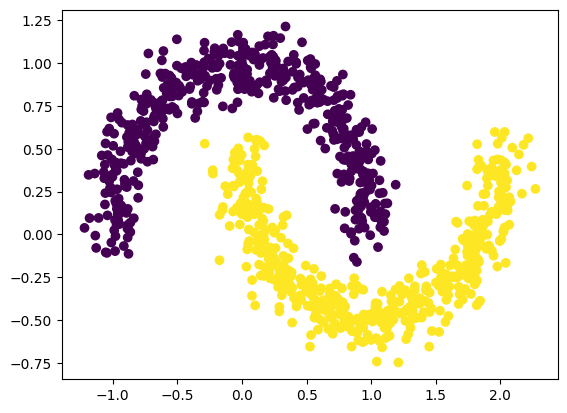

In [24]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [25]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(X[:5], y[:5])

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

tensor([[-0.0515,  0.4442],
        [ 1.0320, -0.4197],
        [ 0.8679, -0.2548],
        [ 0.2889, -0.4487],
        [-0.8334,  0.5351]]) tensor([1., 1., 1., 1., 0.])
torch.Size([800, 2]) torch.Size([800]) torch.Size([200, 2]) torch.Size([200])


## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [26]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
  def __init__(self, input_units, output_units, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_units)
    )

  def forward(self, x):
      return self.linear_layer_stack(x)

# Instantiate the model
model_0 = MoonModelV0(2, 1, 16).to(device)
model_0

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [27]:
# Setup loss function
loss_function = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [28]:
# What's coming out of our model?
with torch.inference_mode():
  y_pred = model_0(X_test.to(device))

# logits (raw outputs of model)
print(f"Logits:\n {y_pred.squeeze()[:5]}")

# Prediction probabilities
print(f"Pred probs:\n {torch.sigmoid(y_pred).squeeze()[:5]}")

# Prediction labels
print(f"Pred labels: \n{torch.round(torch.sigmoid(y_pred)).squeeze()[:5]}")

Logits:
 tensor([-0.1432, -0.1826, -0.1519, -0.2100, -0.1852], device='cuda:0')
Pred probs:
 tensor([0.4643, 0.4545, 0.4621, 0.4477, 0.4538], device='cuda:0')
Pred labels: 
tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [29]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [30]:
## TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  # Training
  model_0.train()

  # 1. Forward pass (logits output)
  y_pred_train = model_0(X_train).squeeze()

  # Turn logits into prediction probabilities
  logits_to_pred_prob_train = torch.sigmoid(y_pred_train)

  # Turn prediction probabilities into prediction labels
  pred_prob_to_pred_labels_train = torch.round(logits_to_pred_prob_train)

  # 2. Calculaute the loss
  train_loss = loss_function(y_pred_train, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  train_accuracy = acc_fn(pred_prob_to_pred_labels_train, y_train) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  train_loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    y_pred_test = model_0(X_test).squeeze()

    # Turn the test logits into prediction labels
    logits_to_pred_prob_test = torch.sigmoid(y_pred_test)
    pred_prob_to_pred_labels_test = torch.round(logits_to_pred_prob_test)

    # 2. Caculate the test loss/acc
    test_loss = loss_function(y_pred_test, y_test)
    test_accuracy = acc_fn(pred_prob_to_pred_labels_test, y_test)


  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f'Epoch {epoch}: Training loss {train_loss}, Training accuracy {train_accuracy * 100}, Testing loss {test_loss}, Testing accuracy {test_accuracy * 100}')

Epoch 0: Training loss 0.6948009133338928, Training accuracy 50.0, Testing loss 0.6731006503105164, Testing accuracy 50.0
Epoch 100: Training loss 0.09433439373970032, Training accuracy 97.25, Testing loss 0.08571115136146545, Testing accuracy 98.0
Epoch 200: Training loss 0.007221495732665062, Training accuracy 100.0, Testing loss 0.005496253725141287, Testing accuracy 100.0
Epoch 300: Training loss 0.002225368982180953, Training accuracy 100.0, Testing loss 0.0017141306307166815, Testing accuracy 100.0
Epoch 400: Training loss 0.0011856292840093374, Training accuracy 100.0, Testing loss 0.0008771996945142746, Testing accuracy 100.0
Epoch 500: Training loss 0.0007895687012933195, Training accuracy 100.0, Testing loss 0.0005378020578064024, Testing accuracy 100.0
Epoch 600: Training loss 0.0005684886709786952, Training accuracy 100.0, Testing loss 0.00035272579407319427, Testing accuracy 100.0
Epoch 700: Training loss 0.00043482205364853144, Training accuracy 100.0, Testing loss 0.0002

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [31]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

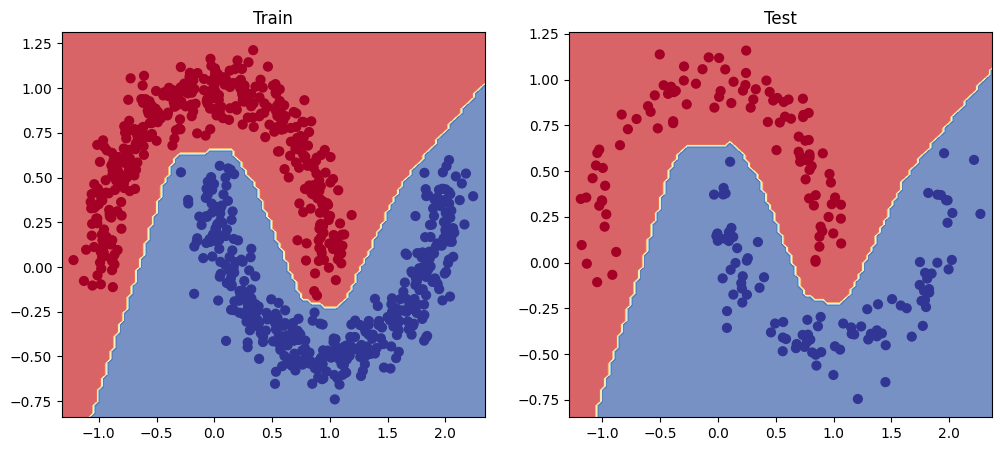

In [47]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)
plt.show()


## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [48]:
# Create a straight line tensor
dummy_tensor = torch.arange(0, 1, 0.01)
dummy_tensor[:10]

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900])

In [49]:
# Test torch.tanh() on the tensor and plot it
tanh_activation_function = torch.tanh(dummy_tensor)
tanh_activation_function[:10]

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0599, 0.0699, 0.0798,
        0.0898])

In [50]:
# Replicate torch.tanh() and plot it
replicate_tanh_activation_function = (torch.exp(dummy_tensor) - torch.exp(-dummy_tensor)) / (torch.exp(dummy_tensor) + torch.exp(-dummy_tensor))
replicate_tanh_activation_function[:10]

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0599, 0.0699, 0.0798,
        0.0898])

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

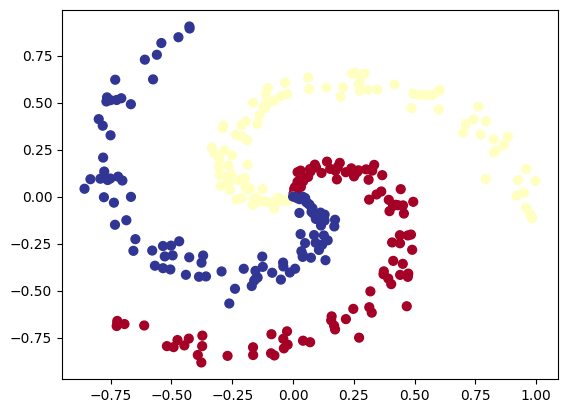

In [60]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [61]:
X[:5], y[:10]

(array([[0.        , 0.        ],
        [0.0001288 , 0.01010019],
        [0.00421814, 0.01975674],
        [0.01251715, 0.027597  ],
        [0.00462762, 0.04013816]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [62]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [63]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [64]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class SpiralModelV0(nn.Module):
  def __init__(self, input_units, output_units, hidden_units=8):
     super().__init__()
     self.neural_network = nn.Sequential(
         nn.Linear(in_features=input_units, out_features=hidden_units),
         nn.ReLU(),
         nn.Linear(in_features=hidden_units, out_features=hidden_units),
         nn.ReLU(),
         nn.Linear(in_features=hidden_units, out_features=output_units)
     )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.neural_network(x)


# Instantiate model and send it to device
model_1 = SpiralModelV0(2, 3, 10).to(device)
model_1

SpiralModelV0(
  (neural_network): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [69]:
# Setup data to be device agnostic
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

with torch.inference_mode():
  y_pred = model_1(X_train)

# Print out first 10 untrained model outputs (forward pass)
print(f"Logits: {y_pred[:10]}")

print(f"Pred probs: {torch.softmax(y_pred, dim=1)[:10]}")

print(f"Pred labels: {torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[:10]}")

Logits: tensor([[-0.3621, -0.2138, -0.2310],
        [-0.3614, -0.2079, -0.2221],
        [-0.3471, -0.2292, -0.2296],
        [-0.2831, -0.2908, -0.2104],
        [-0.2988, -0.2787, -0.2243],
        [-0.3317, -0.2429, -0.2223],
        [-0.3408, -0.2369, -0.2274],
        [-0.3587, -0.2284, -0.2479],
        [-0.3358, -0.2374, -0.2223],
        [-0.2822, -0.2918, -0.2104]], device='cuda:0')
Pred probs: tensor([[0.3030, 0.3515, 0.3455],
        [0.3016, 0.3517, 0.3467],
        [0.3077, 0.3462, 0.3461],
        [0.3260, 0.3235, 0.3506],
        [0.3228, 0.3294, 0.3478],
        [0.3117, 0.3406, 0.3477],
        [0.3096, 0.3435, 0.3468],
        [0.3071, 0.3498, 0.3431],
        [0.3102, 0.3423, 0.3475],
        [0.3263, 0.3232, 0.3506]], device='cuda:0')
Pred labels: tensor([1, 1, 1, 2, 2, 2, 2, 1, 2, 2], device='cuda:0')


In [71]:
# Setup loss function and optimizer
loss_function = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

In [73]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  # Training
  model_1.train()

  # 1. Forward pass
  y_pred_train = model_1(X_train)

  # Turn logits into prediction probabilities
  logits_to_pred_prob_train = torch.softmax(y_pred_train, dim=1)

  # Turn prediction probabilities into prediction labels
  pred_prob_to_pred_labels_train = torch.argmax(logits_to_pred_prob_train, dim=1)

  # 2. Calculate the loss
  train_loss = loss_function(y_pred_train, y_train)

  # Calculate the accuracy
  train_accuracy = acc_fn(pred_prob_to_pred_labels_train, y_train) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  train_loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    y_pred_test = model_1(X_test)

    # Turn logits into prediction probabilities
    logits_to_pred_prob_test = torch.softmax(y_pred_test, dim=1)

    # Turn prediction probabilities into prediction labels
    pred_prob_to_pred_labels_test = torch.argmax(logits_to_pred_prob_test, dim=1)

    # 2. Caculate loss and acc
    test_loss = loss_function(y_pred_test, y_test)

    # Calculate the accuracy
    test_accuracy = acc_fn(pred_prob_to_pred_labels_test, y_test) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f'Epoch {epoch}: Training loss {train_loss}, Training accuracy {train_accuracy * 100}%, Testing loss {test_loss}, Testing accuracy {test_accuracy * 100}%')

Epoch 0: Training loss 1.113919973373413, Training accuracy 15.416666984558105%, Testing loss 1.111790418624878, Testing accuracy 16.666667938232422%
Epoch 100: Training loss 0.3359825313091278, Training accuracy 83.75%, Testing loss 0.3293479084968567, Testing accuracy 85.0%
Epoch 200: Training loss 0.0942031666636467, Training accuracy 97.91667175292969%, Testing loss 0.062498584389686584, Testing accuracy 100.0%
Epoch 300: Training loss 0.052648842334747314, Training accuracy 99.16666412353516%, Testing loss 0.02151172049343586, Testing accuracy 100.0%
Epoch 400: Training loss 0.03775415197014809, Training accuracy 99.16666412353516%, Testing loss 0.011089766398072243, Testing accuracy 100.0%
Epoch 500: Training loss 0.030193276703357697, Training accuracy 99.16666412353516%, Testing loss 0.0063418741337955, Testing accuracy 100.0%
Epoch 600: Training loss 0.025811145082116127, Training accuracy 99.16666412353516%, Testing loss 0.004151629749685526, Testing accuracy 100.0%
Epoch 700

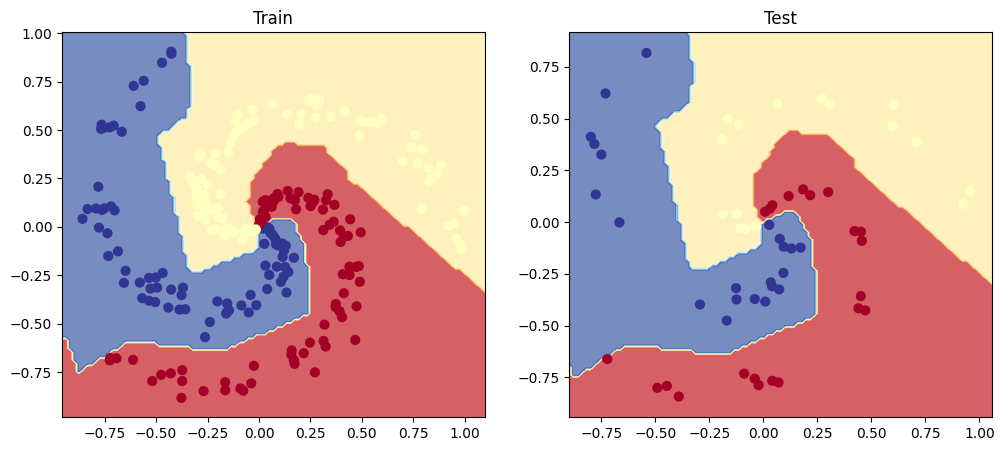

In [74]:
# Plot decision boundaries for training and test sets
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)
plt.show()